In [1]:
import time
import os

import torch

import pytorch_mask_rcnn as pmr
    
# ------------------ adjustable parameters ---------------------
use_cuda = True                              # choose to use GPU or not
visualize_eval = True                        # choose to visualize evaluation results or not
val_num_samples = 3                          # number of samples during test, betweem 1 to 1444
ckpt_path = '../checkpoint.pth'               # path where to save the checkpoint.pth
data_dir = 'E:/PyTorch/data/VOC2012'         # dataset directory
# ------------------ adjustable parameters ---------------------
classes = pmr.dataset.VOC_BBOX_LABEL_NAMES

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
print('cuda: {}\nuse_cuda: {}\n{} GPU(s) available'.format(torch.cuda.is_available(), use_cuda, torch.cuda.device_count()))
print('\ndevice: {}'.format(device))

valset = pmr.VOCDataset(data_dir, 'val', False, device=device) # len=1444
indices = torch.randperm(len(valset)).tolist()
valset = torch.utils.data.Subset(valset, indices[:val_num_samples])

model = pmr.maskrcnn_resnet50(False, 21).to(device)

cuda: True
use_cuda: True
1 GPU(s) available

device: cuda


tensor([], device='cuda:0', size=(0, 4))




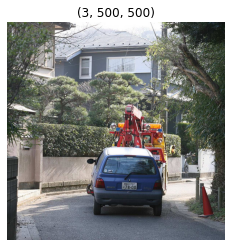

tensor([], device='cuda:0', size=(0, 4))




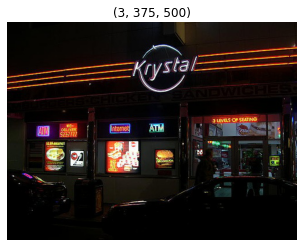

tensor([], device='cuda:0', size=(0, 4))




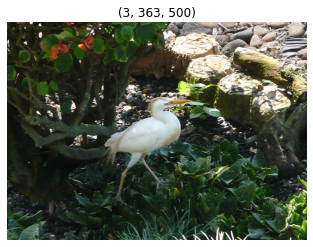

total time: 1.28 s


In [3]:
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    del checkpoint
    torch.cuda.empty_cache()

since = time.time()
# ------------------val---------------------
model.eval()
for image in valset:
    with torch.no_grad():
        results = model(image)
        
    if visualize_eval:
        print(results['boxes'])
        print('  '.join(classes[l] for l in results['labels'].tolist()))
        print('  '.join('{:.2f}'.format(p) for p in results['scores'].tolist()))
        pmr.show(image, results)
# ------------------val---------------------
print('total time: {:.2f} s'.format(time.time() - since))